In [1]:
import collections

from web.models import Article, DateEntity
from nltk import sent_tokenize
from django.shortcuts import _get_queryset

In [2]:
articles = Article.objects.filter(is_ground_truth = 1, classification_score = 1)

In [3]:
def get_object_or_None(klass, *args, **kwargs):
    queryset = _get_queryset(klass)
    try:
        return queryset.get(*args, **kwargs)
    except queryset.model.DoesNotExist:
        return None

<h1>Article classification</h1>

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from plot import plot_confusion_matrix, plot_2d

In [20]:
df = pd.DataFrame.from_records(Article.objects.all().values()) # Load articles into df
df = df.loc[df['is_ground_truth'] == 1] # Only keep labeled data
df['classification_score'] = (df['classification_score'] >= 1).astype(bool) # Convert classification_score to bool
df = df.sample(frac=1) # Shuffle
df.to_csv("~/Desktop/labeled.csv")
positive_size = len(df.loc[df['classification_score'] == True])
print("Articles labeled as strikes: {}.\nRest: {}.".format(positive_size, len(df) - positive_size))

Articles labeled as strikes: 78.
Rest: 122.


Split dataset into equal-sized classes

In [6]:
positive = df.loc[df['classification_score'] == True]
positive_size = positive.shape[0]
negative = df.loc[df['classification_score'] == False].sample(positive_size)

df = pd.concat([positive, negative])
df = df.sample(frac=1)

print("Articles labeled as strikes: {}.\nRest: {}.".format(positive_size, len(df) - positive_size))

Articles labeled as strikes: 78.
Rest: 78.


In [7]:
def classify(df, stopwords, size=None):
    patterns = [re.compile('|'.join(r'{}'.format(word) for word in group), re.IGNORECASE) for group in stopwords]
    return [any(pattern.search(article['body'][:size]) is not None for pattern in patterns) for _, article in df.iterrows()]

In [8]:
def get_FP(df, pred_y, true_y):
    FP = np.logical_and(pred_y == True, true_y == False)
    FP_idx = np.where(FP == True)
    return df.iloc[FP_idx[0],:]

def get_FN(df, pred_y, true_y):
    FN = np.logical_and(pred_y == False, true_y == True)
    FN_idx = np.where(FN == True)
    return df.iloc[FN_idx[0],:]

Specify stopwords to use for classification as well as get true labels

In [9]:
true_y = df['classification_score']
stopwords = (('drone', 'uav', 'unmanned'), ('strike', 'missile'))
pred_y = classify(df, stopwords, size=10000)

In [10]:
FP = get_FP(df, np.array(pred_y), np.array(true_y))
# FP = np.logical_and(np.array(pred_y) == True, np.array(true_y) == False)
# FP_idx = np.where(FP == True)[0]
# FP_idx
print(len(FP))
for body in FP['body']:
    print(body)
    print("--------------------------------------------")

48
Commander Nazir group and its leader Malang Wazir has been desginated among the Specially Designated Global Terrorists by US Statement Department. According to a statement released by US Department of State, the commander Nazir group has been alleged to run training camps for terrorists, sent suicide bombers, provided sanctuary for al Qaeda fighters and conducted cross-border operations against the US and its allies in Afghanistan. The source further added, “In addition to its attacks against international forces in Afghanistan, CNG [commander Nazir group] is also responsible for assassinations and intimidation operations against civilians in Afghanistan and Pakistan.” The statement also added that after the death of Mullah Nazir earlier this year the group had chosen Malang Wazir to become part of their top leadership. The group also issued a statement that they would continue to support al Qaeda and their attacks in Afghanistan. State also noted that the Mullah Nazir Group and Com

Generate character limits for prediction to find optimal

In [11]:
char_limits = [num for num in range(0, 1001, 40)]

preds = [(char_limit, classify(df, stopwords, char_limit)) for char_limit in char_limits]
preds_score = [(char_limit, metrics.accuracy_score(true_y, pred_y)) for char_limit, pred_y in preds]
best = max(preds_score, key=lambda x: x[1])
print("Char size limit {} yields best accuracy with {}".format(*best))

Char size limit 200 yields best accuracy with 0.8846153846153846


[0.5, 0.5384615384615384, 0.7115384615384616, 0.7884615384615384, 0.8717948717948718, 0.8846153846153846, 0.8846153846153846, 0.8846153846153846, 0.8846153846153846, 0.8782051282051282, 0.8717948717948718, 0.8717948717948718, 0.8717948717948718, 0.8717948717948718, 0.8717948717948718, 0.8653846153846154, 0.8589743589743589, 0.8589743589743589, 0.8525641025641025, 0.8525641025641025, 0.8461538461538461, 0.8461538461538461, 0.8397435897435898, 0.8397435897435898, 0.8269230769230769, 0.8205128205128205]


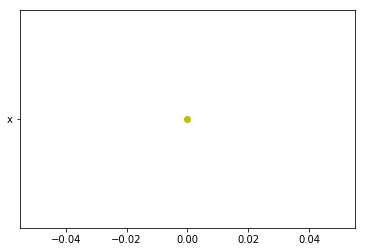

In [12]:
preds_score = [pred_score for _, pred_score in preds_score]
print(preds_score)
scores = pd.DataFrame({'x': char_limits, 'y': preds_score})
plt.plot('x', 'y', data=df, linestyle='-', marker='o')
plt.show()

In [13]:
pred_y = classify(df, stopwords, 100000)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
metrics.accuracy_score(true_y, pred_y) # (TP+TN)/(TP+FP+TN+FN)

0.6923076923076923

In [15]:
print(metrics.classification_report(true_y, pred_y)) 
# Precision: (TP)/(TP+TN)
# Recall: (TP)(TP+FN)
# f1-score: (Rec*Prec)/(Rec + Prec)

              precision    recall  f1-score   support

       False       1.00      0.38      0.56        78
        True       0.62      1.00      0.76        78

   micro avg       0.69      0.69      0.69       156
   macro avg       0.81      0.69      0.66       156
weighted avg       0.81      0.69      0.66       156



Normalized confusion matrix
[[0.38461538 0.61538462]
 [0.         1.        ]]


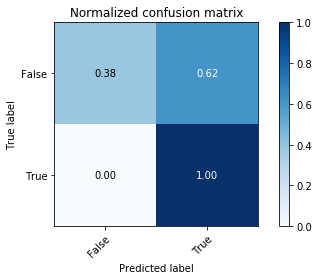

In [16]:
plot_confusion_matrix(true_y, pred_y, ('False', 'True'), normalize=True)

<h1>Data extraction:</h1>

In [17]:
# Get sentence in which label appears in article
def get_sentence_label(label, article=None):
    if(not label):
        return ""
    
    if(not article):
        article = label.seed
    
    len_read = 0
    label = label.get_dict()
    sentences = sent_tokenize(article.body)
    for sentence in sentences:
        if 0 < label['start_index'] - len_read < len(sentence):
            return sentence
        
        len_read += len(sentence)
        
    return sentences[-1]

In [18]:
counter = collections.Counter([])
for article in articles:
    sentence = get_sentence_label(get_object_or_None(DateEntity, seed=article))
    counter += collections.Counter(sentence.split())
print(counter)

Counter({'the': 77, 'in': 56, 'on': 34, 'of': 31, 'carried': 21, 'a': 20, 'out': 20, 'were': 20, 'said': 17, 'airstrike': 16, 'was': 15, 'district.': 15, 'militants': 15, 'killed': 14, 'to': 13, 'The': 12, 'US': 12, 'drone': 12, 'late': 11, 'least': 11, 'According': 10, 'strike': 9, 'Silab': 8, 'Corps': 8, 'statement': 8, 'Wednesday': 8, 'suspected': 8, 'Afghan': 7, 'vicinity': 7, 'At': 7, 'officials,': 7, 'tribal': 7, 'night': 7, '201st': 6, 'government': 6, 'and': 6, 'province': 6, 'officials': 6, 'area': 6, 'local': 6, 'Pakistan': 6, 'security': 6, 'following': 6, 'Military': 5, 'East': 5, 'that': 5, 'airstrikes': 5, 'district': 5, 'provincial': 5, 'Nangarhar': 5, 'A': 5, 'Tuesday.': 5, 'at': 5, 'Waziristan': 5, 'Achin': 4, 'Thursday': 4, 'night.': 4, 'latest': 4, 'media': 4, 'targeted': 4, 'Tuesday': 4, 'Pakistani': 4, 'region': 4, 'forces': 3, 'Haska': 3, 'Mina': 3, 'office': 3, 'past': 3, 'four': 3, 'by': 3, 'Monday,': 3, 'leaving': 3, 'dead.': 3, 'Saturday': 3, 'restive': 3, 'an